# Calculating the solvent density around a protein

 Here we use `density.DensityAnalysis` to analyse the solvent density around an enzyme.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests

**Optional packages for visualisation:**

* nglview
* matplotlib
* scikit-image
* pyvista
* ipygany

Throughout this tutorial we will include cells for visualising Universes with the [NGLView](http://nglviewer.org/nglview/latest/api.html) library. However, these will be commented out, and we will show the expected images generated instead of the interactive widgets.

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import TPR, XTC
from MDAnalysis.analysis import density

import numpy as np
import matplotlib.pyplot as plt
# import nglview as nv
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>). It is solvated in TIP4P water and broken across periodic boundaries.

In [2]:
u = mda.Universe(TPR, XTC)

In [3]:
# view1 = nv.show_mdanalysis(u)
# view1.add_representation(
#     'licorice', 
#     selection='resname SOL',
# )
# view1

In [4]:
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(
#     view1,
#     step=4,  # keep every 4th step
#     render_params={"factor": 3},  # average quality render
#     output='density_analysis_images/density_analysis-view1.gif',
# )
# movie.make()

<center>
<div style='width: 800px'>
    
![view1](density_analysis_images/density_analysis-view1.gif)
    
</div>
</center>

## Centering, aligning, and making molecules whole with on-the-fly transformations

`DensityAnalysis` uses a fixed grid to analyse the density of molecules. As it is likely that this grid may cross the unit cell wall, this means that molecules that have broken across the periodic boundary must be made whole. Because we want to analyse the density of water *around a protein*, this means:

 * that the solvent must be mapped so they are closest to the protein, and
 * we need to align the trajectory on the protein for a fixed frame of reference
 
 In practice, the transformations that we need (in order) are shown in the table below. GROMACS's [trjconv](https://manual.gromacs.org/documentation/2021/onlinehelp/gmx-trjconv.html) is often used to perform these transformations; the equivalent command is also given. MDAnalysis offers [on-the-fly transformations](https://userguide.mdanalysis.org/stable/trajectories/transformations.html) to accomplish much the same task; however, where `trjconv` saves the transformed trajectory into a file, MDAnalysis does not alter the initial trajectory. Instead, it transforms each frame "on-the-fly" as it is loaded into MDAnalysis.
 

| Transformation                                                         	| On-the-fly transformation   	| GROMACS trjconv argument 	|
|------------------------------------------------------------------------	|-----------------------------	|--------------------------	|
| Making molecules whole                                                 	| `wrap.unwrap()`             	| `-pbc whole`             	|
| Moving the protein to the center of the box for more symmetric density 	| `translate.center_in_box()` 	| `-center`                	|
| Wrapping water back into the box                                       	| `wrap.wrap()`               	|                          	|
| Aligning the trajectory onto the protein                               	| `fit.fit_rot_trans()`       	| `-fit rot+trans`         	|

We want wrap water back into the box before we fit the trajectory, in order to avoid odd placements from the rotation in the alignment.
 
 You can do this yourself with external tools such as `gmx trjconv`, using the arguments above. Here, we use on-the-fly transformations so we can avoid writing out new trajectories.

In [5]:
from MDAnalysis import transformations as trans

protein = u.select_atoms('protein')
water = u.select_atoms('resname SOL')

workflow = [trans.unwrap(u.atoms),  # unwrap all fragments
            trans.center_in_box(protein, # move atoms so protein
                                center='geometry'), # is centered
            trans.wrap(water, # wrap water back into box
                       compound='residues'), # keep each water whole
            trans.fit_rot_trans(protein, # align protein to first frame
                                protein,
                                weights='mass'),
           ]

u.trajectory.add_transformations(*workflow)

When we visualise the transformed trajectory, we can see that it is now centered in the box and whole.

In [6]:
# view2 = nv.show_mdanalysis(u)
# view2.add_representation(
#     'licorice',
#     selection='resname SOL',
# )
# view2

In [7]:
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(
#     view2,
#     step=4,  # keep every 4th step
#     render_params={"factor": 3},  # average quality render
#     output='density_analysis_images/density_analysis-view2.gif',
# )
# movie.make()

<center>
<div style='width: 800px'>
    
![view2](density_analysis_images/density_analysis-view2.gif)
    
</div>
</center>

## Analysing the density of water around the protein

Now that the input trajectory has been pre-processed, we can carry out our analysis. We only want to look at the density of numbers of water molecules, so we choose the oxygen atoms only (see [LinearDensity](linear_density.ipynb) for mass and charge density analysis). 

In [8]:
ow = u.select_atoms('name OW')
dens = density.DensityAnalysis(ow, 
                               delta=4.0,
                               padding=2)
dens.run()

The results are stored in `dens.density`, a `Density` object. `dens.density.grid` is a numpy array with the average density of the water oxygen atoms, histogrammed onto a grid with 1 $Å$ spacing on each axis.

In [9]:
grid = dens.results.density.grid
grid.shape

(31, 42, 20)

When first calculated, these are in the default units of $Å^{-3}$.

In [10]:
dens.results.density.units

{'length': 'Angstrom', 'density': 'Angstrom^{-3}'}

You can convert the units both for the length (`convert_length`) and for the density (`convert_density`). MDAnalysis stores a number of precomputed ways to convert units. Densities can be converted to $nm^{-3}$, or converted to a density relative to the bulk density. After executing the code below, the array at `dens.density.grid` now contains the density of water relative to bulk TIP4P water at ambient positions.

In [11]:
dens.results.density.convert_density('TIP4P')
dens.results.density.units

{'length': 'Angstrom', 'density': 'TIP4P'}

## Visualisation

A number of 3D and 2D visualization methods are illustrated below.

### matplotlib (3D static plot)

You may want to visualise your densities as part of your analysis. One trivial way is to plot the density of water around the protein as a 3D scatter plot.

First we need to obtain the x, y, and z axes for the plot by taking the midpoints of the histogram bins. These are stored as `dens.density.midpoints`.

In [12]:
mx, my, mz = dens.results.density.midpoints

In the plot below we represent the density of water in a particular bin with the opacity of the scatter point. To do that, we need to first normalise the density values. In the `flat` vector below before, the highest opacity (i.e. the point with the highest density of water oxygen atoms) is 0.1. The array is also flattened so we can treat it as a list of values.

In [13]:
grid = dens.results.density.grid
flat = grid.ravel() / (grid.max()*10)

We set the colour to an RGBA array representing the colour blue. The last number in an RGBA array represents the alpha channel, which controls the opacity of the point. 

In [14]:
blue = [44, 130, 201, 1]
colors = [blue] * len(mx) * len(my) * len(mz)
colors = np.array(colors, dtype=float)
colors[:, -1] *= flat
colors[:, :3] /= 255

Finally we can plot the points on a 3D plot. `Axes3D` must be imported for a 3D plot, even though we do not directly use it. In this case, the plot is not very interesting; it just looks like a box of water.

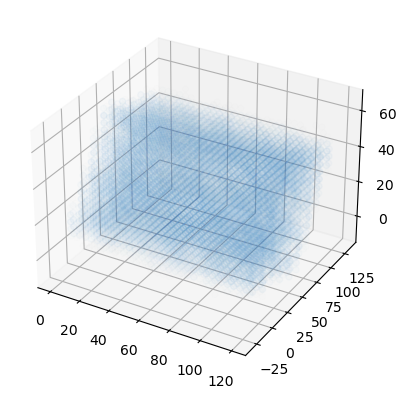

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.meshgrid(mx, my, mz)

ax.scatter(x, y, z, c=colors);

### nglview (interactive)

You could also view the density in NGLView by exporting it to a DX format:

In [16]:
dens.results.density.export("water.dx")

Use the [surface representation](http://nglviewer.org/ngldev/api/file/src/representation/surface-representation.js.html#lineNumber126) in NGLViewer to visualize the loaded density at different isolevels:
- `contour = False` shows a continuous surface (the default); `True` shows a wirefram
- `isolevel = float` sets the contour level and with `isolevel_type="value"` is in the units of the density
- `isolevel_type="value"` for densities (the default is "sigma") and then `isolevel` has a different meanin
- One can use multiple surfaces at different isolevels (although the current example trajectory has too few frames to generate a well resolved density
- `smooth = float` controls the surface smoothing of the representation

In [17]:
# view3 = nv.show_mdanalysis(u)
# d = view3.add_component("water.dx")
# d.clear_representations()
# d.add_surface(isolevel=0.5, isolevel_type="value", opacity=0.1, contour=False, smooth=1, color="blue")
# d.add_surface(isolevel=1.2, isolevel_type="value", opacity=1, contour=True, smooth=1, color="cyan")

# view3

### scikit-image (triangulated surface)

You could use the Marching Cube (Lewiner) algorithm to triangulate the surface (following [this tutorial](https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html#sphx-glr-auto-examples-edges-plot-marching-cubes-py) and [StackOverflow post](https://stackoverflow.com/questions/6030098/how-to-display-a-3d-plot-of-a-3d-array-isosurface-in-matplotlib-mplot3d-or-simil).

This will require the [skimage](https://scikit-image.org/docs/dev/api/skimage.html) library.

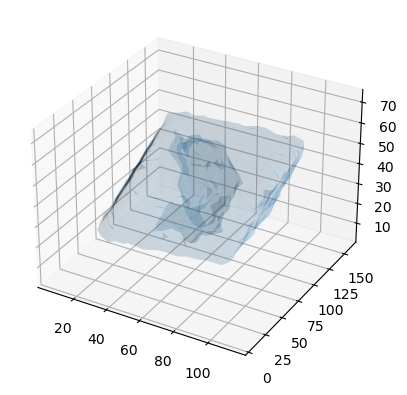

In [18]:
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D

iso_val = 0.5
verts, faces, _, _ = measure.marching_cubes(dens.results.density.grid, iso_val, 
                                                    spacing=dens.results.density.delta)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                lw=1, alpha=0.1);

### pyvista (3D surface)

Similarly, using [PyVista](https://docs.pyvista.org/), you can plot both static and interactive visualizations of the surface at different iso levels (following this [StackOverflow post](https://stackoverflow.com/questions/6030098/how-to-display-a-3d-plot-of-a-3d-array-isosurface-in-matplotlib-mplot3d-or-simil/35472146#35472146)).
Uncomment the last lines to show the plot in your local machine.

In [19]:
import pyvista as pv

pv.set_plot_theme("document")

x, y, z = np.meshgrid(mx, my, mz, indexing="ij")
mesh = pv.StructuredGrid(x, y, z)
mesh["density"] = dens.results.density.grid.T.flatten() # note transpose
contours = mesh.contour([0.5, 1.2])
p = pv.Plotter(notebook=True)
p.background_color = 'white'
p.add_mesh(mesh.outline(), color="k");  # box lines
p.add_mesh(contours, opacity=0.2);  # surfaces
# p.show()
# p.screenshot("./density_analysis_images/surface.png");

![surface](./density_analysis_images/surface.png)

Unfortunately plotting interactively appears to render everything with opaque surfaces. Note that this code snippet requires [ipygany](https://ipygany.readthedocs.io/en/latest/) to be installed.

In [20]:
p = pv.Plotter(notebook=True)
p.background_color = 'white'
p.add_mesh(mesh.outline(), color="k")  # box lines
p.add_mesh(contours, opacity=0.2);  # surfaces
# uncomment the below for interactivity
# p.show(jupyter_backend="ipygany")
# p.screenshot("./density_analysis_images/interactive-surface.png");

### 2D averaging

Alternatively, you could plot the average density of water on the xy-plane. We get the average x-y positions by averaging over the z-axis.

In [21]:
avg = grid.mean(axis=-1)
avg.shape

(31, 42)

Below, it is plotted as a heat map.

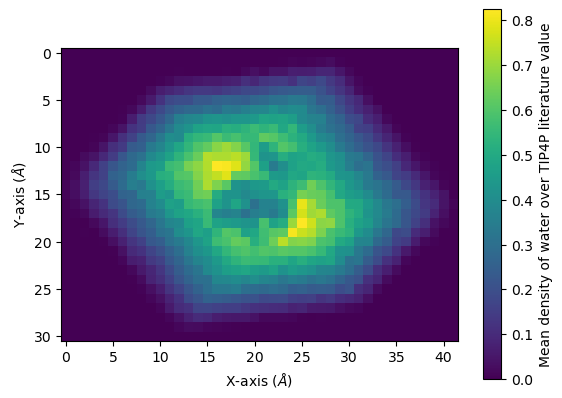

In [22]:
fig, ax = plt.subplots()

im = ax.imshow(avg)
cbar = plt.colorbar(im)
cbar.set_label('Mean density of water over TIP4P literature value')
plt.xlabel('X-axis ($\AA$)')
plt.ylabel('Y-axis ($\AA$)');

You can interpolate values for a smoother average:

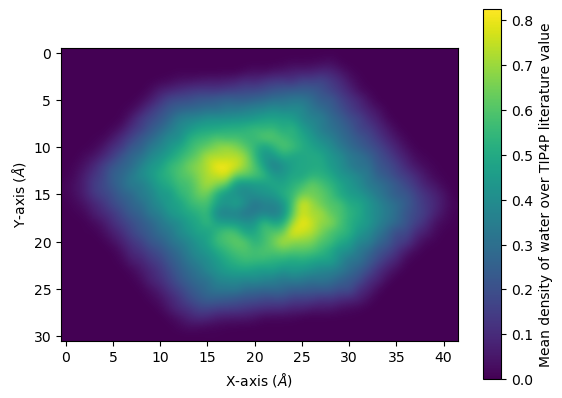

In [23]:
fig, ax = plt.subplots()

im = ax.imshow(avg, interpolation="bicubic")
cbar = plt.colorbar(im)
cbar.set_label('Mean density of water over TIP4P literature value')
plt.xlabel('X-axis ($\AA$)')
plt.ylabel('Y-axis ($\AA$)');

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

